# Practicum 3. HARPS-GTO age estimation


## Figure 8. Distribution of HMPHs, LMPHs, and single stars by ages

### Cell 0 — Setup: пути, save_fig, опции

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from astroquery.vizier import Vizier

root_path = Path.cwd()
while not (root_path / "topics").exists():
    root_path = root_path.parent

topic_root = root_path / "topics/TOP_0001_exoplanet_birth_radius"
RAW   = topic_root / "data/raw"
PROC  = topic_root / "data/processed"
FIG   = topic_root / "figures/en"
PROC.mkdir(parents=True, exist_ok=True)
FIG.mkdir(parents=True, exist_ok=True)

def save_fig(name, fig=None):
    if fig is None:
        fig = plt.gcf()
    out = FIG / f"{name}.png"
    fig.savefig(out, dpi=200, bbox_inches="tight")
    print("Saved:", out)

### Cell 1 — Load SWEET-Cat (локальный CSV)

In [ ]:
sweet = pd.read_csv(RAW / "sweetcat.csv")
sweet = sweet[sweet["SWFlag"] == 1].copy()

# нормализуем имена колонок для удобства
sweet = sweet.rename(columns={"Logg":"logg", "Teff":"Teff", "[Fe/H]":"feh"})
sweet = sweet.dropna(subset=["Teff","logg","feh"])


### Cell 2 — Load HARPS-GTO (Vizier)

In [ ]:
Vizier.ROW_LIMIT = -1
harps = Vizier.get_catalogs("J/A+A/545/A32")[0].to_pandas()

harps = harps.rename(columns={"[Fe/H]":"feh"})
harps = harps.dropna(subset=["Teff","logg","feh","Star","SimbadName"])

### Cell 3 — Load NEA + классификация планет (HMPH/LMPH) + хосты

In [ ]:
import re

nea = pd.read_csv(RAW / "nea_ps_default_flag_1.csv")

def canon_name(x):
    if pd.isna(x): return ""
    s = str(x).strip().lower()
    s = s.replace("–","-").replace("—","-")
    s = re.sub(r"\(.*?\)", "", s)
    s = re.sub(r"\s+", "", s)
    s = re.sub(r"[^a-z0-9+\-]", "", s)
    return s

# host column
host_col = next(c for c in ["hostname","pl_hostname","sy_name","host_name","host"] if c in nea.columns)
nea["host_key"] = nea[host_col].map(canon_name)

# planet mass column (best-effort)
mp_col = next((c for c in ["pl_bmassj","pl_masse","pl_massj"] if c in nea.columns), None)
if mp_col is None:
    raise KeyError("NEA: не нашёл колонку массы планеты (pl_bmassj/pl_massj/pl_masse).")

# приводим к Mjup (если вдруг в Earth masses — грубо конвертим)
mp = pd.to_numeric(nea[mp_col], errors="coerce")
if "masse" in mp_col:
    mp_mj = mp / 317.8
else:
    mp_mj = mp

nea["mp_mj"] = mp_mj

# классы как в статье: high-mass vs low-mass (порог можно подстроить позже)
THRESH_MJ = 0.1  # пример: 0.1 Mj ~ 32 Mearth (порог уточним по статье при необходимости)
nea["planet_class"] = np.where(nea["mp_mj"] >= THRESH_MJ, "HMPH", "LMPH")

# по каждому хосту берём "максимальный" класс (если есть хотя бы одна HMPH -> HMPH)
host_max = (nea.dropna(subset=["host_key","planet_class"])
              .groupby("host_key")["planet_class"]
              .agg(lambda s: "HMPH" if (s=="HMPH").any() else "LMPH")
              .reset_index())

host_class = dict(zip(host_max["host_key"], host_max["planet_class"]))

### Cell 4 — Проставить host/single + class для HARPS

In [ ]:
harps["name1"] = harps["SimbadName"].map(canon_name)
harps["name2"] = harps["Star"].map(canon_name)

harps["is_host"] = harps["name1"].isin(host_class) | harps["name2"].isin(host_class)
harps["class"] = "single"
harps.loc[harps["is_host"], "class"] = harps.loc[harps["is_host"], "name1"].map(host_class)
# fallback на name2
m = harps["class"].isna() & harps["is_host"]
harps.loc[m, "class"] = harps.loc[m, "name2"].map(host_class)

harps["class"] = harps["class"].fillna("single")
harps["class"].value_counts()

single    941
HMPH      132
LMPH       38
Name: class, dtype: int64

### Cell 5 — Построить MIST grid cache (если ещё нет)

In [ ]:
grid_path = PROC / "mist_grid_cache.parquet"

if not grid_path.exists():
    from isochrones.mist import MIST_Isochrone
    iso = MIST_Isochrone()
    grid = iso.model_grid.df.copy()
    grid.to_parquet(grid_path, index=False)
    print("Built & saved:", grid_path, "shape:", grid.shape)
else:
    print("Exists:", grid_path)

Exists: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/data/processed/mist_grid_cache.parquet


### Cell 6 — Возраста (grid-based) для SWEET и HARPS + сохранить CSV

In [ ]:
grid = pd.read_parquet(grid_path).dropna(subset=["age","feh","Teff","logg"]).copy()
# age is log10(years)
grid["age_gyr"] = (10 ** grid["age"]) / 1e9

def fit_age_grid(teff, logg, feh, ete=60.0, elg=0.10, efe=0.04):
    sub = grid[(grid["feh"] >= feh - 3*efe) & (grid["feh"] <= feh + 3*efe)]
    if len(sub) == 0:
        sub = grid[(grid["feh"] >= feh - 0.5) & (grid["feh"] <= feh + 0.5)]
        if len(sub) == 0:
            return np.nan
    chi2 = ((sub["Teff"]-teff)/ete)**2 + ((sub["logg"]-logg)/elg)**2
    return float(sub.loc[chi2.idxmin(), "age_gyr"])

# SWEET ages
sweet["age_gyr"] = [fit_age_grid(t,g,f) for t,g,f in tqdm(zip(sweet.Teff, sweet.logg, sweet.feh),
                                                          total=len(sweet), desc="SWEET ages")]
sweet_ages = sweet[["Teff","logg","feh","age_gyr"]].copy()
sweet_ages.to_csv(PROC / "sweetcat_ages_grid.csv", index=False)

# HARPS ages
harps["age_gyr"] = [fit_age_grid(t,g,f) for t,g,f in tqdm(zip(harps.Teff, harps.logg, harps.feh),
                                                          total=len(harps), desc="HARPS ages")]
harps_ages = harps[["Star","SimbadName","Teff","logg","feh","class","is_host","age_gyr"]].copy()
harps_ages.to_csv(PROC / "harps_ages_grid.csv", index=False)

print("Saved ages to:", PROC)

HARPS ages: 100%|██████████| 1111/1111 [00:08<00:00, 124.80it/s]

Saved ages to: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/data/processed


### Cell 7 — GCE: реконструкция r_birth + сохранить CSV

In [ ]:
R_SUN = 8.0

def grad_dfeh_dr(age_gyr):
    age = np.asarray(age_gyr, float)
    return -0.07 + (-0.15 + 0.07) * (age / 13.5)

def feh_ism_rsun(age_gyr):
    age = np.asarray(age_gyr, float)
    feh_now, feh_early, tau = 0.0, -0.65, 2.5
    x = np.log1p(age/tau) / np.log1p(13.5/tau)
    return feh_now + (feh_early - feh_now) * x

dfh = harps_ages.copy()
dfh = dfh[(dfh["age_gyr"]>=0.1) & (dfh["age_gyr"]<=13.5) & np.isfinite(dfh["age_gyr"])].copy()

grad = grad_dfeh_dr(dfh["age_gyr"].values)
feh0 = feh_ism_rsun(dfh["age_gyr"].values)

dfh["rbirth_kpc"] = (R_SUN + (dfh["feh"].values - feh0)/grad).clip(0.5, 20.0)

dfh.to_csv(PROC / "harps_rbirth_gce.csv", index=False)
print("Saved:", PROC / "harps_rbirth_gce.csv", "Rows:", len(dfh))
print(dfh["class"].value_counts())

Saved: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/data/processed/harps_rbirth_gce.csv Rows: 466
single    385
HMPH       66
LMPH       15
Name: class, dtype: int64


### Cell S1 — SWEET: приклеить класс планет (HMPH/LMPH) к звёздам

In [ ]:
# SWEET columns already normalized earlier? If not:
sweet = pd.read_csv(RAW / "sweetcat.csv")
sweet = sweet[sweet["SWFlag"] == 1].copy()
sweet = sweet.rename(columns={"Logg":"logg", "Teff":"Teff", "[Fe/H]":"feh"})
sweet = sweet.dropna(subset=["Teff","logg","feh","Name"]).copy()

sweet["host_key"] = sweet["Name"].map(canon_name)

# class from NEA host_class dict (HMPH/LMPH)
sweet["is_host"] = sweet["host_key"].isin(host_class)
sweet["class"] = "single"
sweet.loc[sweet["is_host"], "class"] = sweet.loc[sweet["is_host"], "host_key"].map(host_class)
sweet["class"] = sweet["class"].fillna("single")

print(sweet["class"].value_counts())

HMPH      805
LMPH      253
single    125
Name: class, dtype: int64


### Cell S2 — SWEET ages (MIST grid, как в HARPS)

In [ ]:
grid_path = PROC / "mist_grid_cache.parquet"
grid = pd.read_parquet(grid_path).dropna(subset=["age","feh","Teff","logg"]).copy()
grid["age_gyr"] = (10 ** grid["age"]) / 1e9  # age is log10(years)

def fit_age_grid(teff, logg, feh, ete=60.0, elg=0.10, efe=0.04):
    sub = grid[(grid["feh"] >= feh - 3*efe) & (grid["feh"] <= feh + 3*efe)]
    if len(sub) == 0:
        sub = grid[(grid["feh"] >= feh - 0.5) & (grid["feh"] <= feh + 0.5)]
        if len(sub) == 0:
            return np.nan
    chi2 = ((sub["Teff"]-teff)/ete)**2 + ((sub["logg"]-logg)/elg)**2
    return float(sub.loc[chi2.idxmin(), "age_gyr"])

sweet["age_gyr"] = [
    fit_age_grid(t,g,f)
    for t,g,f in tqdm(zip(sweet.Teff, sweet.logg, sweet.feh),
                      total=len(sweet), desc="SWEET ages (grid)")
]

sweet = sweet[(sweet["age_gyr"]>=0.1) & (sweet["age_gyr"]<=13.5) & np.isfinite(sweet["age_gyr"])].copy()

out_ages = PROC / "sweetcat_ages_grid.csv"
sweet[["Name","Teff","logg","feh","class","is_host","age_gyr"]].to_csv(out_ages, index=False)
print("Saved:", out_ages, "Rows:", len(sweet))
print(sweet["class"].value_counts())

SWEET ages (grid): 100%|██████████| 1183/1183 [00:08<00:00, 139.56it/s]

Saved: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/data/processed/sweetcat_ages_grid.csv Rows: 605
HMPH      436
LMPH      101
single     68
Name: class, dtype: int64


### Cell S3 — SWEET $r_{\rm birth}$ via GCE + сохранить CSV

In [ ]:
R_SUN = 8.0

def grad_dfeh_dr(age_gyr):
    age = np.asarray(age_gyr, float)
    return -0.07 + (-0.15 + 0.07) * (age / 13.5)

def feh_ism_rsun(age_gyr):
    age = np.asarray(age_gyr, float)
    feh_now, feh_early, tau = 0.0, -0.65, 2.5
    x = np.log1p(age/tau) / np.log1p(13.5/tau)
    return feh_now + (feh_early - feh_now) * x

grad = grad_dfeh_dr(sweet["age_gyr"].values)
feh0 = feh_ism_rsun(sweet["age_gyr"].values)

sweet["rbirth_kpc"] = (R_SUN + (sweet["feh"].values - feh0)/grad).clip(0.5, 20.0)

out_r = PROC / "sweetcat_rbirth_gce.csv"
sweet[["Name","Teff","logg","feh","class","is_host","age_gyr","rbirth_kpc"]].to_csv(out_r, index=False)
print("Saved:", out_r, "Rows:", len(sweet))

Saved: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/data/processed/sweetcat_rbirth_gce.csv Rows: 605


### Cell S4 — Figure 8 for SWEET and HARPS-GTO v Age and r_birth

Saved: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/figures/en/Figure_8.png


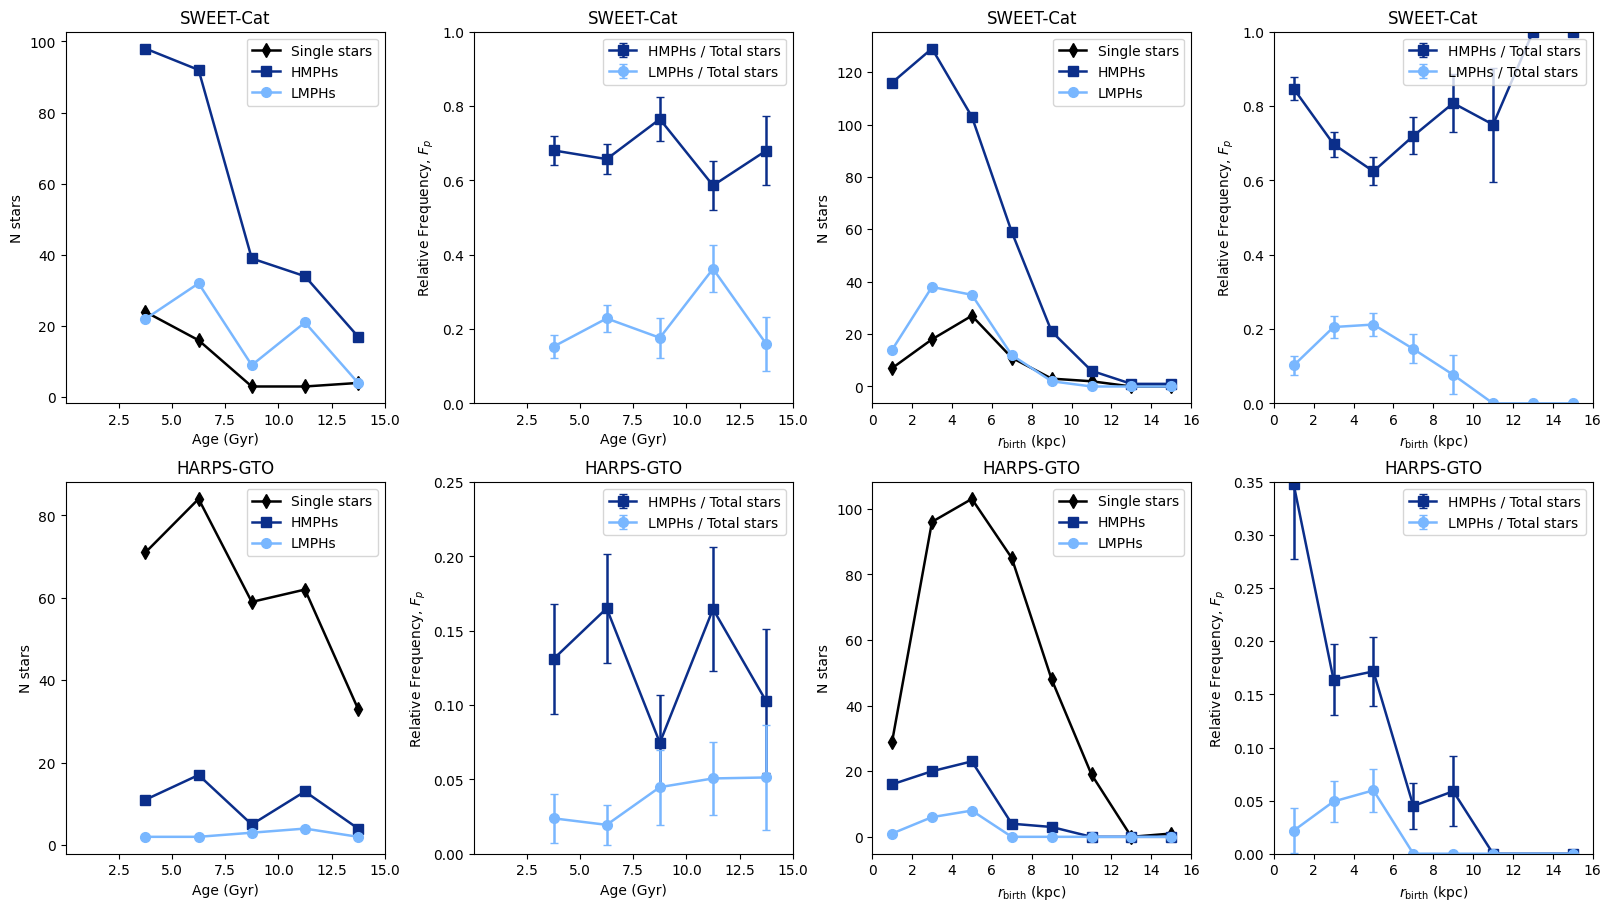

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sweet = pd.read_csv(PROC / "sweetcat_rbirth_gce.csv")
harps = pd.read_csv(PROC / "harps_rbirth_gce.csv")

sweet = sweet[np.isfinite(sweet["age_gyr"]) & np.isfinite(sweet["rbirth_kpc"])].copy()
harps = harps[np.isfinite(harps["age_gyr"]) & np.isfinite(harps["rbirth_kpc"])].copy()

# --- paper-like style ---
COL = {"single":"k", "HMPH":"#0B2E8A", "LMPH":"#79B7FF"}
MRK = {"single":"d", "HMPH":"s", "LMPH":"o"}
LW, MS, CAP = 1.8, 7, 3

def counts_in_bins(df, xcol, bins, cls):
    x = df.loc[df["class"] == cls, xcol].dropna().to_numpy()
    return np.histogram(x, bins=bins)[0]

def frac_and_err(k, n):
    k = np.asarray(k, float)
    n = np.asarray(n, float)
    p = np.full_like(k, np.nan)
    err = np.full_like(k, np.nan)
    m = n > 0
    p[m] = k[m] / n[m]
    err[m] = np.sqrt(np.clip(p[m]*(1-p[m]) / n[m], 0, None))
    return p, err

def plot_block(ax_counts, ax_freq, df, xcol, bins, xcent, xlabel, title,
               freq_ylim=(0,1), mask_bins=None, xlim=None, xticks=None):
    Ns = counts_in_bins(df, xcol, bins, "single")
    Nh = counts_in_bins(df, xcol, bins, "HMPH")
    Nl = counts_in_bins(df, xcol, bins, "LMPH")
    Nt = Ns + Nh + Nl

    if mask_bins is not None:
        Ns, Nh, Nl, Nt = Ns[mask_bins], Nh[mask_bins], Nl[mask_bins], Nt[mask_bins]
        xcent = xcent[mask_bins]

    # counts
    ax_counts.plot(xcent, Ns, marker=MRK["single"], ms=MS, lw=LW, color=COL["single"], label="Single stars")
    ax_counts.plot(xcent, Nh, marker=MRK["HMPH"],   ms=MS, lw=LW, color=COL["HMPH"],   label="HMPHs")
    ax_counts.plot(xcent, Nl, marker=MRK["LMPH"],   ms=MS, lw=LW, color=COL["LMPH"],   label="LMPHs")
    ax_counts.set_title(title)
    ax_counts.set_xlabel(xlabel)
    ax_counts.set_ylabel("N stars")
    ax_counts.legend(loc="upper right", frameon=True)

    # frequency
    ph, eh = frac_and_err(Nh, Nt)
    pl, el = frac_and_err(Nl, Nt)

    m = (Nt > 0) & np.isfinite(ph) & np.isfinite(eh)
    ax_freq.errorbar(xcent[m], ph[m], yerr=eh[m],
                     marker=MRK["HMPH"], ms=MS, lw=LW, capsize=CAP,
                     color=COL["HMPH"], label="HMPHs / Total stars")

    m = (Nt > 0) & np.isfinite(pl) & np.isfinite(el)
    ax_freq.errorbar(xcent[m], pl[m], yerr=el[m],
                     marker=MRK["LMPH"], ms=MS, lw=LW, capsize=CAP,
                     color=COL["LMPH"], label="LMPHs / Total stars")

    ax_freq.set_title(title)
    ax_freq.set_xlabel(xlabel)
    ax_freq.set_ylabel(r"Relative Frequency, $F_p$")
    ax_freq.set_ylim(*freq_ylim)
    ax_freq.legend(loc="upper right", frameon=True)

    if xlim is not None:
        ax_counts.set_xlim(*xlim)
        ax_freq.set_xlim(*xlim)
    if xticks is not None:
        ax_counts.set_xticks(xticks)
        ax_freq.set_xticks(xticks)

# =========================================================
# FIX #2: re-clip rbirth to start at 0 (so HMPHs can pile up near 0 like paper)
# =========================================================
sweet["rbirth_kpc"] = np.clip(sweet["rbirth_kpc"].to_numpy(float), 0.0, 20.0)
harps["rbirth_kpc"] = np.clip(harps["rbirth_kpc"].to_numpy(float), 0.0, 20.0)

# =========================================================
# Binning / ticks like paper
# =========================================================

# Age bins: width 2.5 Gyr (edges), but SHOW starts at 2.5 (we drop first bin 0–2.5)
age_bins = np.arange(0.0, 15.0 + 0.001, 2.5)
age_cent = 0.5*(age_bins[:-1] + age_bins[1:])
mask_age = age_cent >= 2.5

# FIX #1: ticks are BIN EDGES (2.5, 5, 7.5, ...) not centers
age_ticks = age_bins[1:]
age_xlim  = (0.0, 15.0)

# r_birth bins: 0..16 step 2
r_bins  = np.arange(0.0, 16.0 + 0.001, 2.0)
r_cent  = 0.5*(r_bins[:-1] + r_bins[1:])
r_ticks = np.arange(0, 17, 2)
r_xlim  = (0.0, 16.0)

# =========================================================
# Combined Figure_8: 2 rows x 4 cols
# =========================================================
fig = plt.figure(figsize=(16, 9), constrained_layout=True)
gs = fig.add_gridspec(2, 4)

ax = {}
ax["s_age_cnt"] = fig.add_subplot(gs[0,0]); ax["s_age_frq"] = fig.add_subplot(gs[0,1])
ax["h_age_cnt"] = fig.add_subplot(gs[1,0]); ax["h_age_frq"] = fig.add_subplot(gs[1,1])
ax["s_r_cnt"]   = fig.add_subplot(gs[0,2]); ax["s_r_frq"]   = fig.add_subplot(gs[0,3])
ax["h_r_cnt"]   = fig.add_subplot(gs[1,2]); ax["h_r_frq"]   = fig.add_subplot(gs[1,3])

# SWEET
plot_block(ax["s_age_cnt"], ax["s_age_frq"], sweet, "age_gyr",
           age_bins, age_cent, "Age (Gyr)", "SWEET-Cat",
           freq_ylim=(0,1), mask_bins=mask_age, xlim=age_xlim, xticks=age_ticks)

plot_block(ax["s_r_cnt"], ax["s_r_frq"], sweet, "rbirth_kpc",
           r_bins, r_cent, r"$r_{\rm birth}$ (kpc)", "SWEET-Cat",
           freq_ylim=(0,1), xlim=r_xlim, xticks=r_ticks)

# HARPS (zoomed frequency axes like paper)
plot_block(ax["h_age_cnt"], ax["h_age_frq"], harps, "age_gyr",
           age_bins, age_cent, "Age (Gyr)", "HARPS-GTO",
           freq_ylim=(0,0.25), mask_bins=mask_age, xlim=age_xlim, xticks=age_ticks)

plot_block(ax["h_r_cnt"], ax["h_r_frq"], harps, "rbirth_kpc",
           r_bins, r_cent, r"$r_{\rm birth}$ (kpc)", "HARPS-GTO",
           freq_ylim=(0,0.35), xlim=r_xlim, xticks=r_ticks)

save_fig("Figure_8", fig)
plt.show()

### Figure 9 - HARPS

/var/folders/_b/cfj7mly10r9f3nkywrlqnl300000gn/T/ipykernel_52112/12621227.py:32: RuntimeWarning: invalid value encountered in divide
  p = np.where(n > 0, k / n, np.nan)
/var/folders/_b/cfj7mly10r9f3nkywrlqnl300000gn/T/ipykernel_52112/12621227.py:34: RuntimeWarning: divide by zero encountered in divide
  denom = 1.0 + (z**2)/n
/var/folders/_b/cfj7mly10r9f3nkywrlqnl300000gn/T/ipykernel_52112/12621227.py:35: RuntimeWarning: divide by zero encountered in divide
  center = (p + (z**2)/(2*n)) / denom
/var/folders/_b/cfj7mly10r9f3nkywrlqnl300000gn/T/ipykernel_52112/12621227.py:36: RuntimeWarning: divide by zero encountered in divide
  half = (z * np.sqrt((p*(1-p) + (z**2)/(4*n)) / n)) / denom


Saved: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/figures/en/Figure_9.png


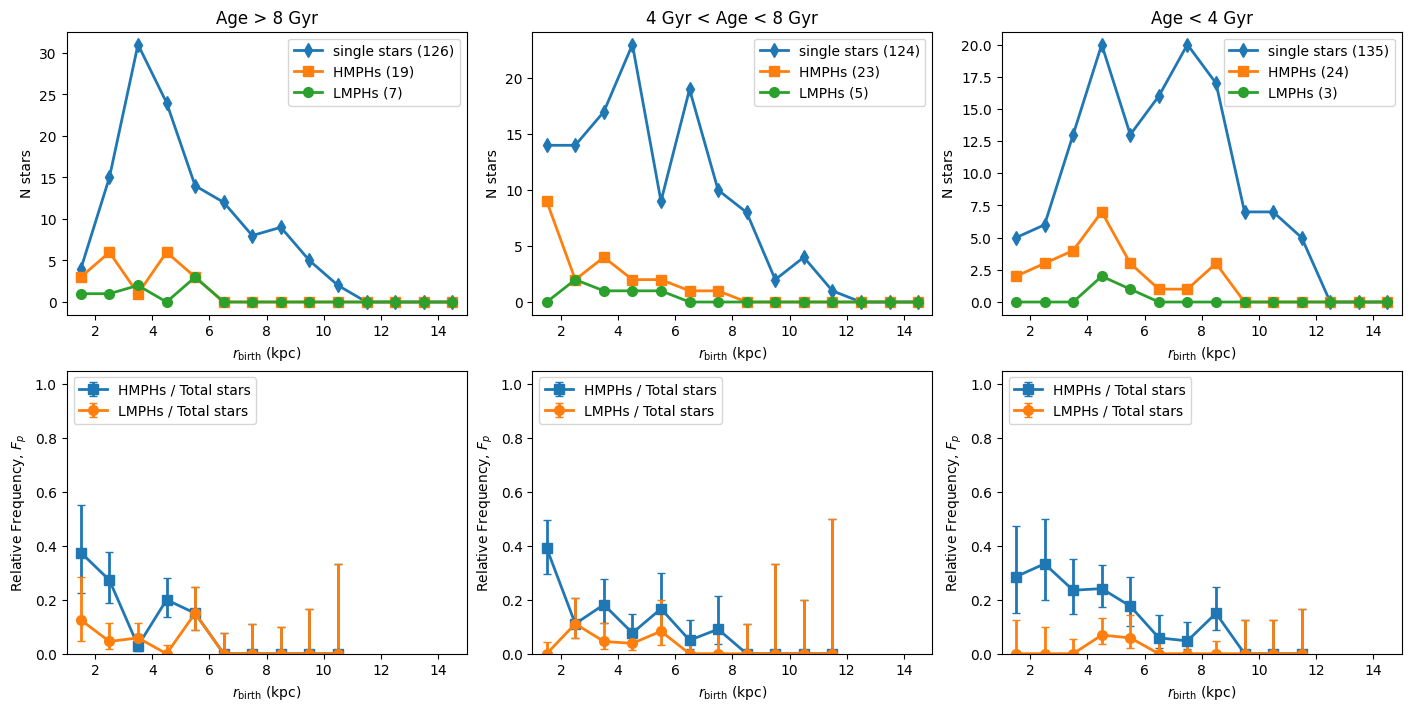

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# --- load if needed ---
csv_path = PROC / "harps_rbirth_gce.csv"
df = dfh.copy() if "dfh" in globals() else pd.read_csv(csv_path)

# Ensure required cols
need = {"rbirth_kpc","age_gyr","class"}
miss = need - set(df.columns)
if miss:
    raise KeyError(f"Missing columns in HARPS table: {miss}")

# --- paper-like bins ---
age_bins = [(8.0, 13.5), (4.0, 8.0), (0.1, 4.0)]
age_titles = ["Age > 8 Gyr", "4 Gyr < Age < 8 Gyr", "Age < 4 Gyr"]

# Use the paper-like range 1–15 kpc (matches your screenshot better)
rbins = np.arange(1.0, 16.0, 1.0)   # edges: 1..15
rcent = 0.5 * (rbins[:-1] + rbins[1:])

def hist_counts(sub, cls):
    x = sub.loc[sub["class"] == cls, "rbirth_kpc"].dropna().to_numpy()
    return np.histogram(x, bins=rbins)[0]

# --- Wilson score interval (binomial), 68% (~1σ) ---
def wilson_interval(k, n, z=1.0):
    k = np.asarray(k, dtype=float)
    n = np.asarray(n, dtype=float)
    p = np.where(n > 0, k / n, np.nan)

    denom = 1.0 + (z**2)/n
    center = (p + (z**2)/(2*n)) / denom
    half = (z * np.sqrt((p*(1-p) + (z**2)/(4*n)) / n)) / denom

    lo = center - half
    hi = center + half
    return p, lo, hi

fig, axes = plt.subplots(2, 3, figsize=(14, 7), constrained_layout=True)

for j, (a0, a1) in enumerate(age_bins):
    sub = df[(df["age_gyr"] >= a0) & (df["age_gyr"] < a1)].copy()

    Ns = hist_counts(sub, "single")
    Nh = hist_counts(sub, "HMPH")
    Nl = hist_counts(sub, "LMPH")
    Nt = Ns + Nh + Nl

    # ---------- Top panel: counts ----------
    ax = axes[0, j]
    ax.plot(rcent, Ns, marker="d", markersize=7, linewidth=2, label=f"single stars ({int((sub['class']=='single').sum())})")
    ax.plot(rcent, Nh, marker="s", markersize=7, linewidth=2, label=f"HMPHs ({int((sub['class']=='HMPH').sum())})")
    ax.plot(rcent, Nl, marker="o", markersize=7, linewidth=2, label=f"LMPHs ({int((sub['class']=='LMPH').sum())})")
    ax.set_title(age_titles[j])
    ax.set_xlabel(r"$r_{\rm birth}$ (kpc)")
    ax.set_ylabel("N stars")
    ax.set_xlim(rbins[0], rbins[-1])
    ax.legend(loc="upper right")

    # ---------- Bottom panel: relative frequency with error bars ----------
    ax = axes[1, j]

    # HMPH fraction
    ph, loh, hih = wilson_interval(Nh, Nt, z=1.0)
    # LMPH fraction
    pl, lol, hil = wilson_interval(Nl, Nt, z=1.0)

    # error bars: asymmetric
    eh_low  = ph - loh
    eh_high = hih - ph
    el_low  = pl - lol
    el_high = hil - pl

    ax.errorbar(
        rcent, ph,
        yerr=np.vstack([eh_low, eh_high]),
        marker="s", markersize=7, linewidth=2, capsize=3,
        label="HMPHs / Total stars"
    )
    ax.errorbar(
        rcent, pl,
        yerr=np.vstack([el_low, el_high]),
        marker="o", markersize=7, linewidth=2, capsize=3,
        label="LMPHs / Total stars"
    )

    ax.set_xlabel(r"$r_{\rm birth}$ (kpc)")
    ax.set_ylabel(r"Relative Frequency, $F_p$")
    ax.set_ylim(0, 1.05)
    ax.set_xlim(rbins[0], rbins[-1])
    ax.legend(loc="upper left")

save_fig("Figure_9", fig)
plt.show()

While the qualitative trends agree with the literature, the detailed shape of the distributions differs due to the use of a simplified GCE model and an independent age reconstruction.

## Why exact reproduction is hard

In principle, using the same observational data and the same published methodology should lead to similar results. In practice, however, exact reproduction of published figures is often difficult, even when all major ingredients appear to be available. This is not a failure of the scientific method, but rather a reflection of how complex, data-driven analyses are actually performed. Many intermediate choices — such as quality cuts, binning schemes, acceptable parameter ranges, or the treatment of outliers — are rarely fully documented, yet they can have a noticeable impact on the final visual appearance of the results.

In addition, physically motivated reconstructions (such as stellar ages or Galactic birth radii) rely on models that are themselves approximate and degenerate. Small differences in assumed Galactic chemical evolution, age–metallicity relations, or uncertainty handling can shift stars between bins and subtly reshape distributions, while preserving the underlying physical trends. As a result, independently reconstructed figures may differ in detail, even when they remain fully consistent at a qualitative and interpretative level.

Importantly, the scientific conclusions of such studies are not based on the exact height of individual histogram bins, but on robust, reproducible trends that persist under reasonable variations of the assumptions. Reproducing these qualitative behaviors — rather than pixel-perfect figures — is therefore the correct benchmark for validation. Exact agreement typically requires access to additional, implicit methodological choices or direct communication with the original authors, which reflects standard practice in modern astrophysical research rather than a lack of rigor.

## References

[1] *“Where in the Milky Way do exoplanets preferentially form?”* (Teixeira, Adibekyan, Bossini et al., 2025) [https://arxiv.org/pdf/2501.11660](https://arxiv.org/pdf/2501.11660)

[2] *"Exploring the Sun’s birth radius and the distribution of planet building blocks in the Milky Way galaxy: a multizone Galactic chemical evolution approach"* (Junichi Baba, Takayuki R. Saitoh and Takuji Tsujimoto, 2023) [https://academic.oup.com/mnras/article/526/4/6088/7324836](https://academic.oup.com/mnras/article/526/4/6088/7324836?login=false)
